# *Covid19* - Variation in CO2 Emission from Europe’s electricity system

In [1]:
import sys
import os
from qgis.core import *
from qgis.PyQt.QtGui import *
from qgis.PyQt.QtCore import *

## QGIS inicialization

In [2]:
QgsApplication.setPrefixPath(r'C:\Program Files\QGIS 3.12\apps\qgis', True)
qgs = QgsApplication([], True)
qgs.initQgis()
sys.path.append(r'C:\Program Files\QGIS 3.12\apps\qgis\python\plugins')

In [3]:
study = QgsProject.instance()

## Import Map Layer

In [4]:
eu_path = "files/countries/ne_10m_admin_0_countries.shp"
eu_layer = QgsVectorLayer(eu_path, 'EU Map', 'ogr')

if not eu_layer.isValid():
    print("Failed to load the layer!")
else:
    study.addMapLayer(eu_layer)

## Read CSV with Pandas

In [5]:
import pandas as pd
V = pd.read_csv("files/csv/paises.csv")
V.head(V.shape[0])

,Pais,Value
0,Italy,-23
1,Spain,-18
2,France,-17
3,Romania,-16
4,Slovenia,-16
5,Belgium,-16
6,United Kingdom,-15
7,Portugal,-12
8,Greece,-12
9,Slovakia,-12


In [6]:
E = pd.read_csv("files/csv/emissoes.csv")
E.head(E.shape[0])

,Source,Value
0,Emission,-39
1,Lignite,-43
2,Hard Coal,-42
3,Other fossil,-39
4,Gas,-30
5,Nuclear,-16
6,All Fuels,-14
7,Wind,-1
8,Other renewables,2
9,Hydro,9


## Variation Graphic with Matplotlib

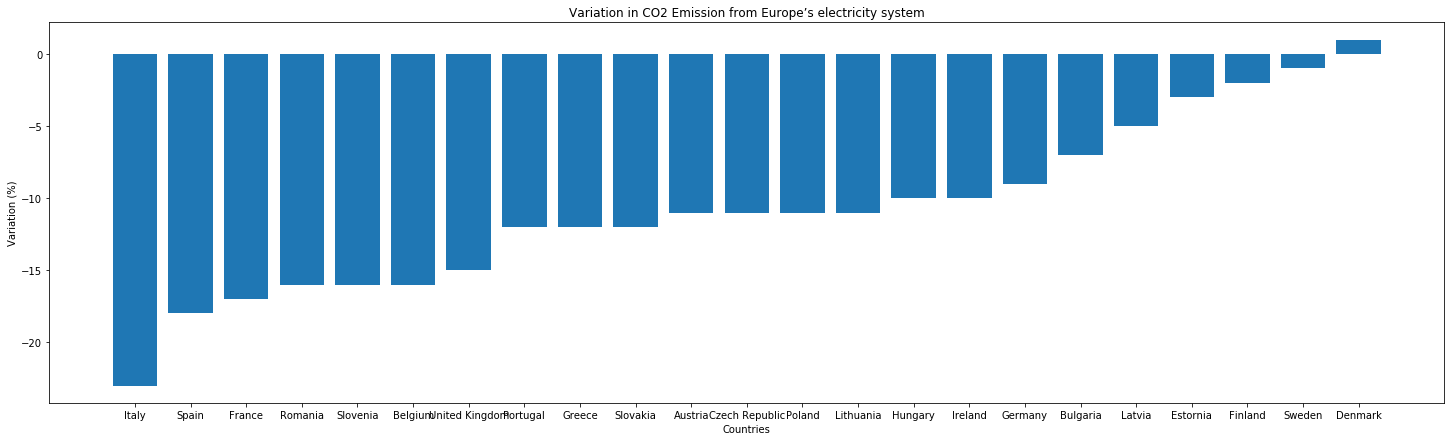

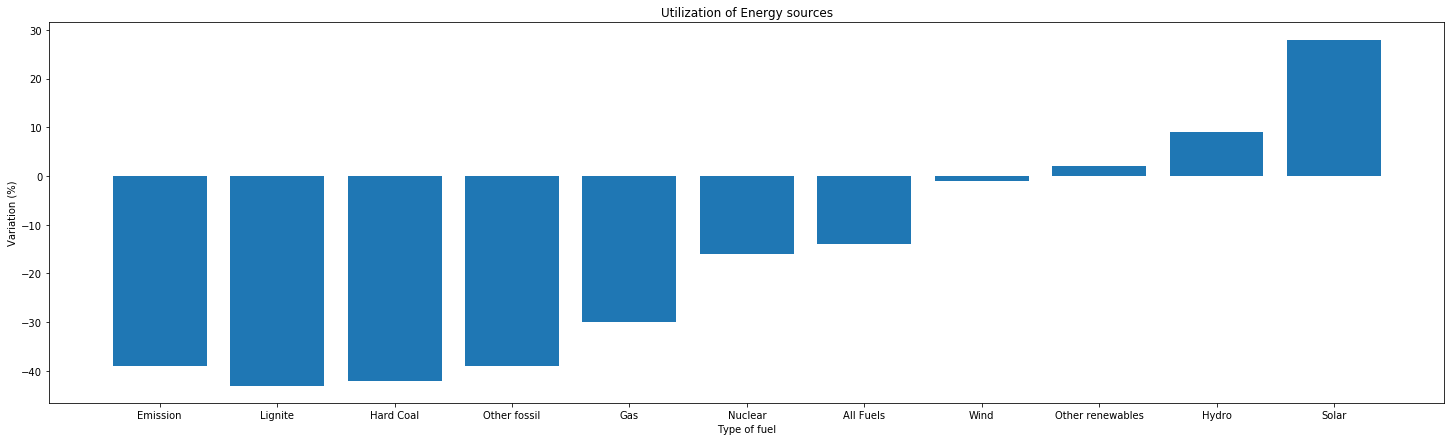

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 7))
plt.bar(V.Pais, V.Value)
plt.xlabel('Countries')
plt.ylabel('Variation (%)')
plt.title('Variation in CO2 Emission from Europe’s electricity system')
plt.show()

plt.figure(figsize=(25, 7))
plt.bar(E.Source,E.Value)
plt.xlabel('Type of fuel')
plt.ylabel('Variation (%)')
plt.title('Utilization of Energy sources')
plt.show()

In [ ]:
#load csv

valores = ['paises']

def loadCSVVectorLayer(aux):
    val_path = "file:files/csv/{}.csv".format(aux)
    layer_name = '{}'.format(aux)
    val_layer = QgsVectorLayer(val_path, layer_name, 'delimitedtext')

    if not val_layer.isValid():
        print('Layer failed to load!')
    else:
        study.addMapLayer(val_layer)
        
for aux in valores:
    loadCSVVectorLayer(aux)

In [ ]:
targetField = 'NAME_EN'
joinField = 'Pais'

In [ ]:
def joinCSVSHPVectorLayers(csv_layer):
    joinObject = QgsVectorLayerJoinInfo()
    joinObject.setJoinFieldName(joinField)
    joinObject.setTargetFieldName(targetField)
    joinObject.setJoinLayerId(csv_layer.id())
    joinObject.setUsingMemoryCache(True)
    joinObject.setJoinLayer(csv_layer)
    flag = eu_layer.addJoin(joinObject)
    return flag
    
layer_name = 'paises'
csv_layer = study.mapLayersByName(layer_name)[0]
flag = joinCSVSHPVectorLayers(csv_layer)

In [ ]:
lista = ['Italy', 'Spain', 'France']
paises = []

for feature in eu_layer.getFeatures():
    if feature['NAME_EN'] in NAME_EN:
        paises.append(feature['NAME_EN'])
        print(feature['NAME_EN'])